In [2]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymc3 as pm
import scipy.stats as stats

In [3]:
def posterior_grid_approx(grid_points=5, success=4, tosses=15, prior="uniform"):
    """"""
    # define grid
    p_grid = np.linspace(0, 1, grid_points)

    # define prior
    if prior == "uniform":
        prior = np.repeat(5, grid_points)
    elif prior == "truncated":    
        prior = (p_grid >= 0.5).astype(int)
    elif prior == "double_exp":
        prior = np.exp(- 5 * abs(p_grid - 0.5))
    else: 
        print("Invalid prior definition")
        return
        
    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(success, tosses, p_grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    
    df = pd.DataFrame({'p_grid': p_grid, 'prior': prior, 'likelihood': likelihood, 'unstd_posterior': unstd_posterior, 'posterior': posterior })
    return df

 ### Ex. 1

Suppose the globe tossing data (Chapter 2) had turned out to be 4 water and 11 land. Construct the posterior distribution, using grid approximation. Use the same flat prior as in the book.

In [4]:
df = posterior_grid_approx(grid_points=10000,success=4, tosses=15, prior="uniform")
df

,p_grid,prior,likelihood,unstd_posterior,posterior
0,0.0000,5,0.000000e+00,0.000000e+00,0.000000e+00
1,0.0001,5,1.364045e-13,6.820223e-13,2.182690e-16
2,0.0002,5,2.180071e-12,1.090036e-11,3.488463e-15
3,0.0003,5,1.102447e-11,5.512237e-11,1.764092e-14
4,0.0004,5,3.480446e-11,1.740223e-10,5.569270e-14
...,...,...,...,...,...
9995,0.9996,5,5.722361e-35,2.861180e-34,9.156693e-38
9996,0.9997,5,2.417814e-36,1.208907e-35,3.868890e-39
9997,0.9998,5,2.796358e-38,1.398179e-37,4.474621e-41
9998,0.9999,5,1.365956e-41,6.829779e-41,2.185748e-44


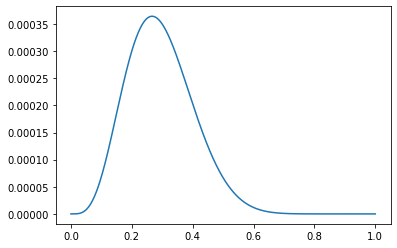

In [6]:
plt.plot(df.p_grid, df.posterior)

In [19]:
samples = np.random.choice(df.p_grid, p=df.posterior, size=10000, replace=True)

### Ex. 2

Now suppose the data are 4 water and 2 land. Compute the posterior again, but this time use a prior that is zero below p = 0.5 and a constant above p = 0.5. This corresponds to prior information that a majority of the Earth’s surface is water.

In [7]:
df2 = posterior_grid_approx(grid_points=10000, success=4, tosses=6,prior="truncated")
df2

,p_grid,prior,likelihood,unstd_posterior,posterior
0,0.0000,0,0.000000e+00,0.000000e+00,0.000000e+00
1,0.0001,0,1.500300e-15,0.000000e+00,0.000000e+00
2,0.0002,0,2.400000e-14,0.000000e+00,0.000000e+00
3,0.0003,0,1.214757e-13,0.000000e+00,0.000000e+00
4,0.0004,0,3.838463e-13,0.000000e+00,0.000000e+00
...,...,...,...,...,...
9995,0.9996,1,2.396641e-06,2.396641e-06,2.169298e-09
9996,0.9997,1,1.348650e-06,1.348650e-06,1.220719e-09
9997,0.9998,1,5.996400e-07,5.996400e-07,5.427588e-10
9998,0.9999,1,1.499700e-07,1.499700e-07,1.357440e-10


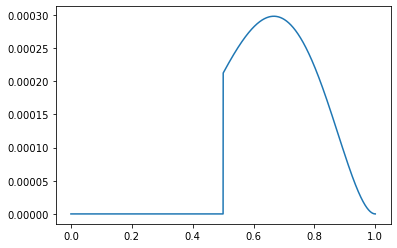

In [8]:
plt.plot(df2.p_grid, df2.posterior)

### Ex. 3

For the posterior distribution from 2,compute 89% percentile and HPDI intervals. Compare the widths of these intervals. Which is wider? Why? If you had only the information in the interval, what might you misunderstand about the shape of the posterior distribution?

In [9]:
samples = np.random.choice(df2.p_grid, p=df2.posterior, size=10000, replace=True)

#percentile
low_pi, high_pi = np.percentile(samples, [4, 96])
print(low_pi, high_pi)

0.5177517751775178 0.891989198919892


In [10]:
#hdi
low_hdi, high_hdi = az.hdi(samples, hdi_prob=0.89)
print(low_hdi, high_hdi)

0.5000500050005001 0.8413841384138414


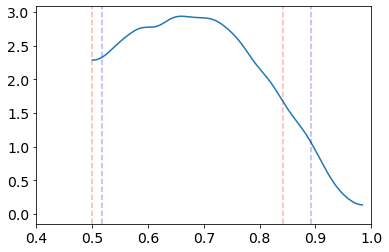

In [12]:
az.plot_kde(samples)
plt.xlim(.4, 1)

plt.axvline(low_hdi, color='r',linestyle='--',alpha=0.3)
plt.axvline(high_hdi, color='r',linestyle='--',alpha=0.3)

plt.axvline(low_pi, color='b',linestyle='--',alpha=0.3)
plt.axvline(high_pi, color='b',linestyle='--',alpha=0.3)

The percentile is misleading because it actually excludes an area (on the very left of the distribution) with high probability density. High density interval gives a more appropriate information about the area with the highest probability density).